## Create Monte Carlo method to integrate posterior

In [ ]:
%pylab inline
import mcint
import numpy.random
from Chempy.parameter import ModelParameters
from Chempy.cem_function import posterior_function_for_integration,posterior_function_many_stars
a = ModelParameters()

### TEST with different random generators e.g. gaussian

### Can we speed up posterior_function_for_integration? 
Limiting factor is the 51 iterations of likelihood function... (takes ~3ms each)

In [ ]:
# Define function to return posterior predictions (must be exponentiated)
def posterior(theta):
    a = ModelParameters()
    post = posterior_function_for_integration(theta)
    posterior = np.exp(post)
    return posterior

sigma = [] # Read prior sigma from parameter file
for i,param_name in enumerate(a.to_optimize):
    sigma.append(a.priors.get(param_name)[1])
    
def sampler(i):
    while True:
        yield random.uniform(np.array(a.p0)-Nsigma[i]*np.array(sigma),np.array(a.p0)+Nsigma[i]*np.array(sigma),size=6)


In [ ]:
Nsamples = [5000,10000,100000] # No MC samples
Nsigma = [1,2,2.5,3,3.5] # Width in parameter space
j = 0
integral = []
integral_err = []
for i in range(len(Nsigma)):
    print('Calculating integral %d of %d' %(i,len(Nsigma)))
    domain_size = np.prod(sigma)*(2*Nsigma[i])**len(sigma) # Total domain size
    result,error = mcint.integrate(posterior,sampler(i),n=Nsamples[j],measure=domain_size)
    integral.append(result)
    integral_err.append(error)

In [ ]:
plt.errorbar(Nsigma,integral,yerr=integral_err)
plt.xlabel('Nsigma')
plt.ylabel('Integral value')

In [ ]:
integral_err

In [ ]:
%timeit -r 1 -n 1 result, error = mcint.integrate(posterior, sampler(),n=Nsamples,measure=domain_size)  

In [ ]:
print(result,error)

In [ ]:
d1 = []
d2 = []
d3 = []
Nsigma = 3
for i in range(1000):
    param = random.uniform(np.array(a.p0)-Nsigma*np.array(sigma),np.array(a.p0)+Nsigma*np.array(sigma),size=6)
    param[2] = a.p0[2]
    param[3] = a.p0[3]
    param[4] = a.p0[4]
    param[5] = a.p0[5]
    post = posterior_function_for_integration(param)
    posterior = np.exp(post)
    d1.append(param[0])
    d2.append(param[1])
    d3.append(posterior)


In [ ]:
plt.scatter(d1,d2,c=(d3))
plt.colorbar()

In [ ]:
%timeit _ = posterior_function_for_integration([-3.,-3.,-0.8,-0.5,0.6,0.5])

In [ ]:
plt.scatter(d1,d3)


In [ ]:
%timeit posterior([-3.,-3.,-0.8,-0.5,0.6,0.5])

## New posterior function with error marginalization

In [ ]:
from Chempy.cem_function import posterior_function_many_stars

def posterior(theta):
    a = ModelParameters()
     post,_ = posterior_function_many_stars(np.array(param),np.inf,a.elements_to_trace)
    posterior = np.exp(post)
    return posterior

In [ ]:
a = ModelParameters()
param = [-3,-3,-0.8,-0.3,0.5,0.6]
pos,abun = posterior_function_many_stars(np.array(param),np.inf,a.elements_to_trace)

In [ ]:
pos,abun = posterior_function_many_stars(np.array(param),np.inf,a.elements_to_trace)

In [ ]:
sol_dat = np.load('Chempy/input/stars/Proto-sun.npy')
sol_dat[1]

In [ ]:
b

In [ ]:
proto_sun = np.load('Chempy/input/stars/Proto-sun.npy')
element_list = np.unique(proto_sun.dtype.names,a.elements_to_trace)[0][:-1]
print(element_list)

**Spare code**

def posterior_function_for_integration(changing_parameter,a):
	'''
	This is the posterior function for a single star with beta-error model.
	
	Beta error marginalization MUST be used for this.	
	
	This is for speeding up Bayes' factor integration	
	'''
	from .data_to_test import likelihood_evaluation
	
	# the values in a are updated according to changing_parameters and the prior list is appended
	a = extract_parameters_and_priors(changing_parameter, a)
	
	# the log prior is calculated
	prior = sum(np.log(a.prior))

	# call Chempy and return the abundances at the end of the simulation = time of star's birth and the corresponding element names as a list
	abundance_list,elements_to_trace = cem_real2(a)
		
	abundance_list = abundance_list[:-2]
	elements_to_trace = elements_to_trace[:-2]

	proto_sun = np.load('Chempy/input/stars/Proto-sun.npy')
	element_list = np.unique(proto_sun.dtype.names,elements_to_trace)[0][:-1] # Remove age
	
	## likelihood is calculated (the model error vector is expanded)
	from scipy.stats import beta
	likelihood_list = []
	model_errors = np.linspace(a.flat_model_error_prior[0],a.flat_model_error_prior[1],a.flat_model_error_prior[2])
	error_weight = beta.pdf(model_errors, a = a.beta_error_distribution[1], b = a.beta_error_distribution[2])
	error_weight/= sum(error_weight)
	
	for item in model_errors:
		error_temp = np.ones(len(element_list)) * item 
		likelihood_list.append(likelihood_evaluation(error_temp[:,None], proto_sun[1] , abundance_list, proto_sun[0]))
		likelihood = logsumexp(likelihood_list, b = error_weight)	
	
	likelihood,_,_,_,_ = likelihood_function(a.stellar_identifier, abundance_list, elements_to_trace)

	return(prior+likelihood)

## Try new MC integration package

In [1]:
%pylab inline
from skmonaco import mcmiser
from Chempy.parameter import ModelParameters
from Chempy.cem_function import posterior_function_mcmc_quick
from Chempy.score_function import preload_params_mcmc
a = ModelParameters()
preload = preload_params_mcmc()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define function to return posterior predictions (must be exponentiated)
def posterior(theta):
    a = ModelParameters()
    post,_ = posterior_function_mcmc_quick(theta,np.inf,a,preload)
    posterior = np.exp(post)
    return posterior

sigma = [] # Read prior sigma from parameter file
for i,param_name in enumerate(a.to_optimize):
    sigma.append(a.priors.get(param_name)[1])
sigma = np.array(sigma)

In [ ]:
Nsamples = [5000,10000,100000] # No MC samples
Nsigma = [1,2,2.5,3,3.5] # Width in parameter space
j = 0
integral = []
integral_err = []
for i in range(len(Nsigma)):
    print('Calculating integral %d of %d' %(i+1,len(Nsigma)))
    result,error = mcmiser(posterior,npoints=Nsamples[j],xl=a.p0-Nsigma[i]*sigma,xu=a.p0+Nsigma[i]*sigma)
    integral.append(result)
    integral_err.append(error)

In [ ]:
plt.errorbar(Nsigma,integral,yerr=integral_err)

In [ ]:
%timeit -r 1 -n 1 posterior([-3.,-3.,-0.8,-0.3,0.5,0.6])

In [ ]:
print(integral)
print(integral_err)

In [3]:
d1 = []
d2 = []
d3 = []
a.p0 = np.array([-2.58,-2.82,-0.86,-0.31,0.55,0.51])
Nsigma = 3
for i in range(5000):
    param = random.uniform(np.array(a.p0)-Nsigma*np.array(sigma),np.array(a.p0)+Nsigma*np.array(sigma),size=6)
    param[2] = a.p0[2]
    param[3] = a.p0[3]
    param[4] = a.p0[4]
    param[5] = a.p0[5]
    post,_ = posterior_function_mcmc_quick(param,np.inf,a,preload)
    posterior = np.exp(post)
    d1.append(param[0])
    d2.append(param[1])
    d3.append(posterior)
    if i%100==0:
        print(i)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


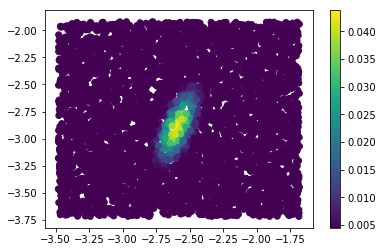

In [7]:
plt.scatter(d1,d2,c=(d3),vmin = 10**-2.35)
plt.colorbar()

In [5]:
max(np.log10(d3))

-1.3585813897491978

In [ ]:
preload.model_errors

In [ ]:
preload.error_weight